# Profiling in Julia

Notebook showing basic profiling Julia modules. Here with essential graphs operations.

## No profiling

In [2]:
module Graphs

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A = Array{Int64,2}(N, N)

    for i=1:N, j=1:N
      A[i,j] = 0
    end

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition()
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler()
  if length(partition()) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str()
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
    global graph = GraphVertex[]

    A = generate_random_graph()
    nodes = generate_random_nodes()
    convert_to_graph(A, nodes)

    str = graph_to_str()
    # println(str)
    check_euler()
  end
end

end

Graphs

In [3]:
import Graphs

@time Graphs.test_graph()

 11.272288 seconds (122.42 M allocations: 6.558 GiB, 10.80% gc time)


In [4]:
Profile.clear()
@profile Graphs.test_graph()

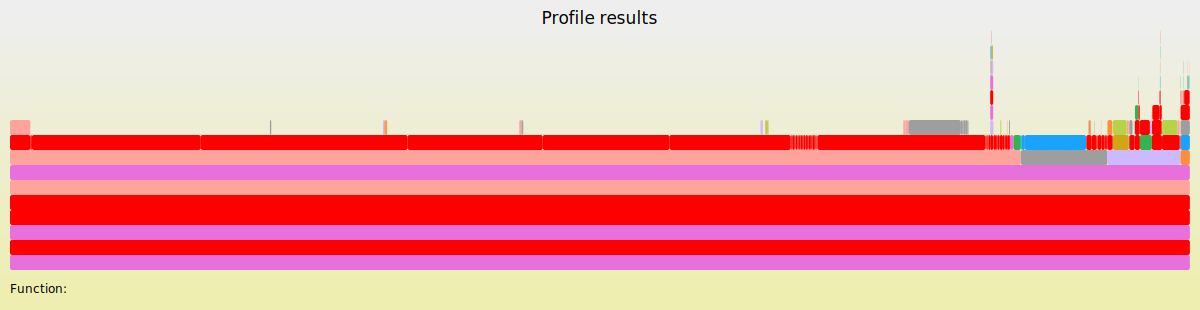

In [5]:
using ProfileView
ProfileView.view()

In [6]:
@allocated Graphs.test_graph()

7007331958

## Vectorizing init loop 

In [14]:
module GraphsProfiling1

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A = zeros(N, N)

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition()
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler()
  if length(partition()) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str()
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
    global graph = GraphVertex[]

    A = generate_random_graph()
    nodes = generate_random_nodes()
    convert_to_graph(A, nodes)

    str = graph_to_str()
    # println(str)
    check_euler()
  end
end

end

GraphsProfiling1

In [15]:
import GraphsProfiling1

@time GraphsProfiling1.test_graph()

  3.122571 seconds (13.46 M allocations: 3.991 GiB, 9.66% gc time)


In [16]:
Profile.clear()
@profile GraphsProfiling1.test_graph()

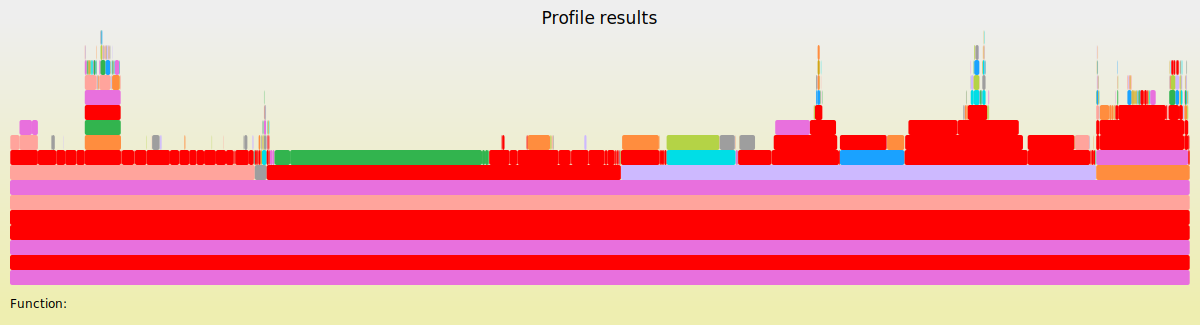

In [17]:
using ProfileView
ProfileView.view()

In [18]:
@allocated GraphsProfiling1.test_graph()

4277417984

## Removing global variables

In [22]:
module GraphsProfiling2

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A = zeros(N, N)

    for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      A[row,col] = 1
      A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes, graph)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  for i = 1:N, j = 1:N
      if A[i,j] == 1
        push!(graph[i].neighbors, graph[j])
      end
  end
  graph
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition(graph)
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler(graph)
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str(graph)
  graph_str = ""
  for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  for i=1:100
    graph = GraphVertex[]

    A = generate_random_graph()
    nodes = generate_random_nodes()
    graph = convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end


GraphsProfiling2

In [23]:
import GraphsProfiling2

@time GraphsProfiling2.test_graph()

  2.919770 seconds (11.82 M allocations: 3.964 GiB, 15.10% gc time)


In [50]:
Profile.clear()
@profile GraphsProfiling2.test_graph()

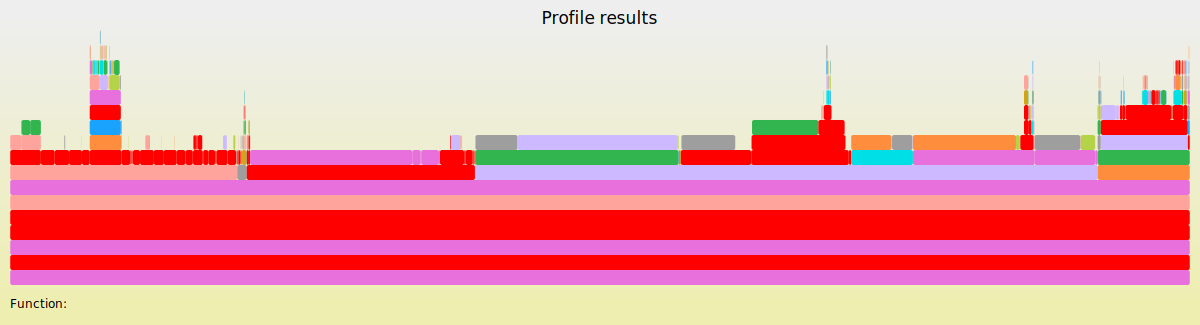

In [51]:
using ProfileView
ProfileView.view()

In [26]:
@allocated GraphsProfiling2.test_graph()

4246705456

## Optimization macros

In [29]:
module GraphsProfiling3

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A = zeros(N, N)

    @simd for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      @inbounds A[row,col] = 1
      @inbounds A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  @simd for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes, graph)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  @elapsed for i = 1:N, j = 1:N
      @inbounds if A[i,j] == 1
        @inbounds push!(graph[i].neighbors, graph[j])
      end
  end
  graph
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition(graph)
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    @simd for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler(graph)
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str(graph)
  graph_str = ""
  @simd for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  @simd for i=1:100
    graph = GraphVertex[]

    A = generate_random_graph()
    nodes = generate_random_nodes()
    graph = convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end


GraphsProfiling3

In [30]:
import GraphsProfiling3

@time GraphsProfiling3.test_graph()

  2.901814 seconds (10.75 M allocations: 3.933 GiB, 14.55% gc time)


In [31]:
Profile.clear()
@profile GraphsProfiling3.test_graph()

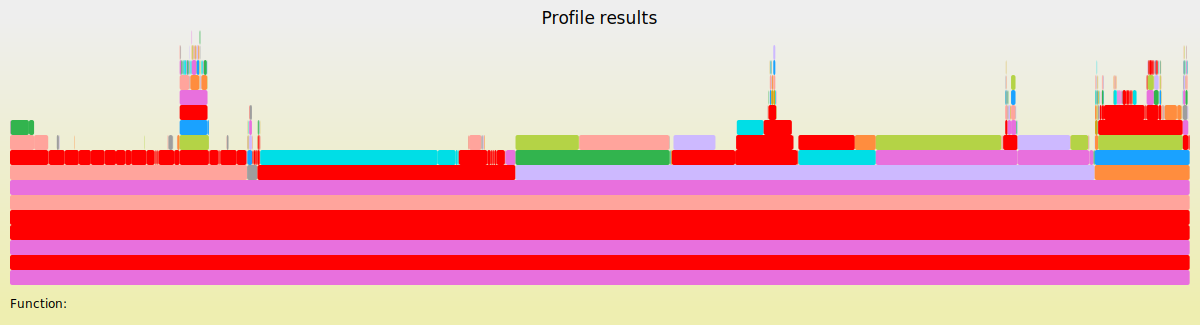

In [32]:
using ProfileView
ProfileView.view()

In [33]:
@allocated GraphsProfiling3.test_graph()

4213153824

## Adding type declarations

In [39]:
module GraphsProfiling4

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A = zeros(N, N)

    @simd for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      @inbounds A[row,col] = 1
      @inbounds A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes = Vector()
  @simd for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes, graph)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  @elapsed for i = 1:N, j = 1:N
      @inbounds if A[i,j] == 1
        @inbounds push!(graph[i].neighbors, graph[j])
      end
  end
  graph
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition(graph)
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    @simd for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler(graph)
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str(graph)
  graph_str::String = ""
  @simd for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  @simd for i=1:100
    graph::Array{GraphsProfiling4.GraphVertex,1} = GraphVertex[]

    A::Any = generate_random_graph()
    nodes::Array{Any,1} = generate_random_nodes()
    graph = convert_to_graph(A, nodes, graph)

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end


GraphsProfiling4

In [40]:
import GraphsProfiling4

@time GraphsProfiling4.test_graph()

  2.960714 seconds (10.76 M allocations: 3.932 GiB, 15.31% gc time)


In [41]:
Profile.clear()
@profile GraphsProfiling4.test_graph()

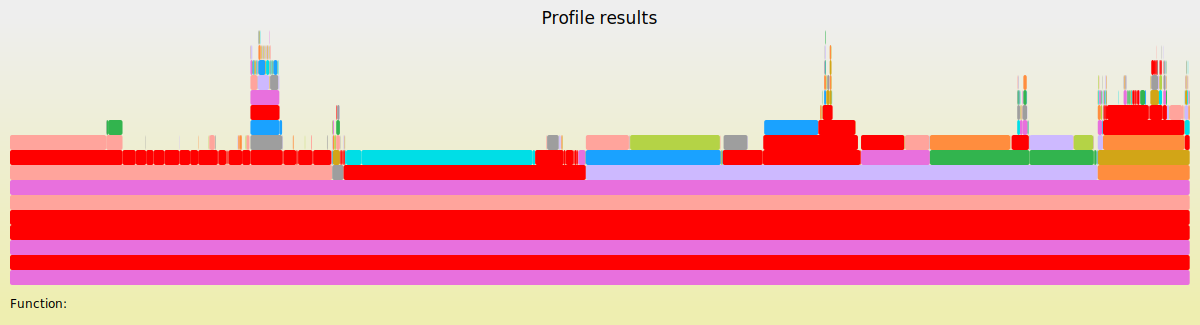

In [42]:
using ProfileView
ProfileView.view()

In [43]:
@allocated GraphsProfiling4.test_graph()

4212494848

## Better memory allocation

In [45]:
module GraphsProfiling5

using StatsBase

export GraphVertex, NodeType, Person, Address,
       generate_random_graph, get_random_person, get_random_address, generate_random_nodes,
       convert_to_graph,
       bfs, check_euler, partition,
       graph_to_str, node_to_str,
       test_graph

#= Single graph vertex type.
Holds node value and information about adjacent vertices =#
mutable struct GraphVertex
  value
  neighbors ::Vector
end

# Types of valid graph node's values.
abstract type NodeType end

mutable struct Person <: NodeType
  name
end

mutable struct Address <: NodeType
  streetNumber
end


# Number of graph nodes.
N = 800

# Number of graph edges.
K = 10000


#= Generates random directed graph of size N with K edges
and returns its adjacency matrix.=#
function generate_random_graph()
    A::Any = zeros(N, N)

    @simd for i in sample(1:N*N, K, replace=false)
      row, col = ind2sub(size(A), i)
      @inbounds A[row,col] = 1
      @inbounds A[col,row] = 1
    end
    A
end

# Generates random person object (with random name).
function get_random_person()
  Person(randstring())
end

# Generates random person object (with random name).
function get_random_address()
  Address(rand(1:100))
end

# Generates N random nodes (of random NodeType).
function generate_random_nodes()
  nodes::Array{Any,1} = Vector()
  @simd for i= 1:N
    push!(nodes, rand() > 0.5 ? get_random_person() : get_random_address())
  end
  nodes
end

#= Converts given adjacency matrix (NxN)
  into list of graph vertices (of type GraphVertex and length N). =#
function convert_to_graph(A, nodes, graph)
  N = length(nodes)
  push!(graph, map(n -> GraphVertex(n, GraphVertex[]), nodes)...)

  @elapsed for i = 1:N, j = 1:N
      @inbounds if A[i,j] == 1
        @inbounds push!(graph[i].neighbors, graph[j])
      end
  end
  graph
end

#= Groups graph nodes into connected parts. E.g. if entire graph is connected,
  result list will contain only one part with all nodes. =#
function partition(graph)
  parts = []
  remaining = Set(graph)
  visited = bfs(remaining=remaining)
  push!(parts, Set(visited))

  while !isempty(remaining)
    new_visited = bfs(visited=visited, remaining=remaining)
    push!(parts, new_visited)
  end
  parts
end

#= Performs BFS traversal on the graph and returns list of visited nodes.
  Optionally, BFS can initialized with set of skipped and remaining nodes.
  Start nodes is taken from the set of remaining elements. =#
function bfs(;visited=Set(), remaining=Set(graph))
  first = next(remaining, start(remaining))[1]
  q = [first]
  push!(visited, first)
  delete!(remaining, first)
  local_visited = Set([first])

  while !isempty(q)
    v = pop!(q)

    @simd for n in v.neighbors
      if !(n in visited)
        push!(q, n)
        push!(visited, n)
        push!(local_visited, n)
        delete!(remaining, n)
      end
    end
  end
  local_visited
end

#= Checks if there's Euler cycle in the graph by investigating
   connectivity condition and evaluating if every vertex has even degree =#
function check_euler(graph)
  if length(partition(graph)) == 1
    return all(map(v -> iseven(length(v.neighbors)), graph))
  end
    "Graph is not connected"
end

#= Returns text representation of the graph consisiting of each node's value
   text and number of its neighbors. =#
function graph_to_str(graph)
  graph_str::String = ""
  @simd for v in graph
    graph_str *= "****\n"

    n = v.value
    if isa(n, Person)
      node_str = "Person: $(n.name)\n"
    else isa(n, Address)
      node_str = "Street nr: $(n.streetNumber)\n"
    end

    graph_str *= node_str
    graph_str *= "Neighbors: $(length(v.neighbors))\n"
  end
  graph_str
end

#= Tests graph functions by creating 100 graphs, checking Euler cycle
  and creating text representation. =#
function test_graph()
  @simd for i=1:100
    graph::Array{GraphsProfiling5.GraphVertex,1} = convert_to_graph(generate_random_graph(), generate_random_nodes(), GraphVertex[])

    str = graph_to_str(graph)
    # println(str)
    check_euler(graph)
  end
end

end


GraphsProfiling5

In [46]:
import GraphsProfiling5

@time GraphsProfiling5.test_graph()

  2.855016 seconds (10.74 M allocations: 3.932 GiB, 11.75% gc time)


In [47]:
Profile.clear()
@profile GraphsProfiling5.test_graph()

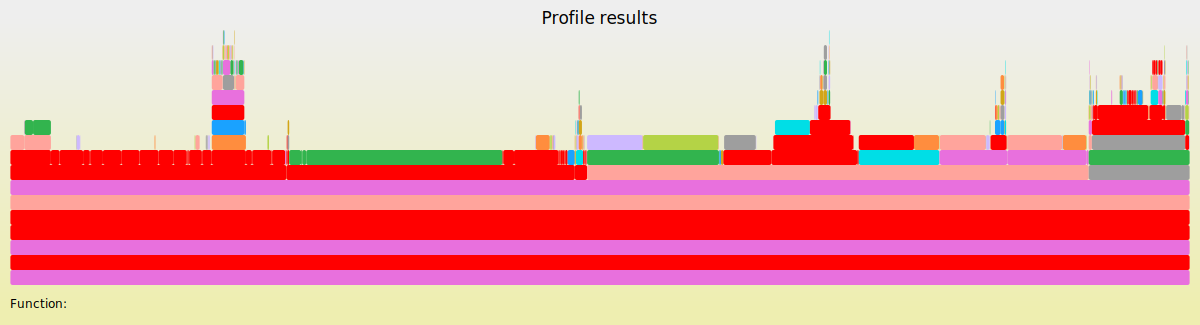

In [48]:
using ProfileView
ProfileView.view()

In [49]:
@allocated GraphsProfiling5.test_graph()

4212498928

## Summary

After reviewing results it's clear that the most important change was vectorizing array creation.
Further refactoring improved performance only a little. 